## 배터리 최적화(휴리스틱)

### 데이터 전처리

In [74]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd


# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)

cloudyDay = data['cloudyDay'].flatten().reshape(-1, 1)

clearDay = data['clearDay'].flatten().reshape(-1, 1)

loadData = data['loadData'][:, 2].reshape(-1, 1)

costData = data['costData'].flatten().reshape(-1, 1)

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(cloudyDay), "차원" , cloudyDay.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


### 데이터 처리

In [75]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1  # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

# Battery/PV parameters
panelArea = 2500
panelEff = 0.3

battEnergy = 2500 * 3.6e6
Einit = 0.5 * battEnergy
batteryMinMaxEmax = 0.8 * battEnergy
batteryMinMaxEmin = 0.2 * battEnergy
batteryMinMaxPmin = -400e3
batteryMinMaxPmax = 400e3

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))
cloudyPpv = panelArea * panelEff * np.tile(cloudyDay[2::stepAdjust], (numDays, 1))
clearPpv = panelArea * panelEff * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadSelect = 1
loadBase = 350e3
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1)) + loadBase

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
# Ppv = cloudyPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt

/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_11769/2575060488.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


### 배터리 최적화(휴리스틱 최적화)

In [91]:
def rule_based_control(Ppv, Pload, Ebatt, minSOC, maxSOC, Pmin, Pmax, time):
    Pgrid = np.zeros_like(Pload)  # 전력 그리드 초기화
    Pbatt = np.zeros_like(Pload)  # 배터리 전력 초기화
    Pcmd = np.zeros_like(Pload)   # 명령 전력 초기화

    for i in range(len(Pload)):
        # 배터리 충전량이 최소 SOC 이하인지 확인
        if Ebatt <= minSOC:
            # 부하 감축: 태양광 발전량이 부족하여 그리드로부터 전력을 가져옴
            Pgrid[i] = max(0, Pload[i] - Ppv[i])
            
        # 시간이 지정된 시간 범위 내에 있는지 확인
        # 8~11, 12~13, 18~22 
        elif (28800 <= time[i] < 39600 or 43200 <= time[i] < 46800 or 64800 <= time[i] < 79200) and minSOC < Ebatt < maxSOC:
            print(i, "Medium")
            # 부하가 태양광보다 클 때
            if Pload[i] > Ppv[i]:
                if Pload[i] - Ppv[i] < Pmin:
                    # 충전: 배터리를 태양광 발전량으로 충전함
                    Pbatt[i] = min(Ppv[i] - Pload[i], maxSOC - Ebatt)
                    Ebatt += Pbatt[i]
                else:
                    # MPPT 끔: 배터리 충전량이 최대 충전 가능량을 초과함
                    Pbatt[i] = 0
                    Pcmd[i] = Pmin
            # 태양광이 부하보다 클 때
            elif Ppv[i] > Pload[i]:
                if Ppv[i] - Pload[i] < Pmax: # Pmax -> 수소 탱크 최대 저장량보다 작으면
                    # 부하 감축: 태양광 발전량이 부하보다 많으므로 그리드에 전력을 공급하지 않음
                    Pgrid[i] = max(0, Pload[i] - Ppv[i]) # -> 잉여 전력을 수소 탱크에 저장하는 코드를 작성
                else:
                    # Pcmd를 Pmax로 설정: 배터리를 사용하여 그리드에 최대 전력을 공급함
                    Pcmd[i] = Pmax # 저장할 수 있는 만큼 저장하고 나머지 전력은 그리드 판매
            # Pcmd가 Pmin과 같을 때
            if Pcmd[i] == Pmin:
                # 방전: 배터리를 사용하여 그리드에 전력을 공급함
                Pbatt[i] = min(Ppv[i] - Pload[i], Ebatt - minSOC)
                Ebatt -= Pbatt[i]

        # 시간이 11-12, 13-18
        elif ((39600 <= time[i] < 43200) or (46800 <= time[i] < 64800) or (time[i] >= 79200)) and minSOC < Ebatt < maxSOC:
            print(i, "Heavy")
            # 피크 시간: 그리드에 최대 전력을 공급함
            # Pcmd[i] = Pmax

        # 22시 이후인 경우
        elif ((time[i] >= 79200) or (time[i] < 28800 )) and minSOC < Ebatt < maxSOC:
            Pgrid[i] = max(0, Pload[i] - Ppv[i])
            print(i, "Light")

        # 배터리 충전량이 최대 SOC 이상인 경우
        elif Ebatt >= maxSOC:
            # MPPT 끔: 배터리 충전량이 최대 충전 가능량을 초과함
            Pbatt[i] = 0
            print(i, "4")

    return Pgrid, Pbatt, Pcmd

# Usage
Pgrid, Pbatt, Pcmd= rule_based_control(Ppv, Pload, Einit, batteryMinMaxEmin, batteryMinMaxEmax, batteryMinMaxPmin, batteryMinMaxPmax, time)


0 Light
1 Light
2 Light
3 Light
4 Light
5 Light
6 Light
7 Light
8 Light
9 Light
10 Light
11 Light
12 Light
13 Light
14 Light
15 Light
16 Light
17 Light
18 Light
19 Light
20 Light
21 Light
22 Light
23 Light
24 Light
25 Light
26 Light
27 Light
28 Light
29 Light
30 Light
31 Light
32 Light
33 Light
34 Light
35 Light
36 Light
37 Light
38 Light
39 Light
40 Light
41 Light
42 Light
43 Light
44 Light
45 Light
46 Light
47 Light
48 Light
49 Light
50 Light
51 Light
52 Light
53 Light
54 Light
55 Light
56 Light
57 Light
58 Light
59 Light
60 Light
61 Light
62 Light
63 Light
64 Light
65 Light
66 Light
67 Light
68 Light
69 Light
70 Light
71 Light
72 Light
73 Light
74 Light
75 Light
76 Light
77 Light
78 Light
79 Light
80 Light
81 Light
82 Light
83 Light
84 Light
85 Light
86 Light
87 Light
88 Light
89 Light
90 Light
91 Light
92 Light
93 Light
94 Light
95 Medium
96 Medium
97 Medium
98 Medium
99 Medium
100 Medium
101 Medium
102 Medium
103 Medium
104 Medium
105 Medium
106 Medium
107 Medium
108 Medium
109 Me

### 그래프 출력

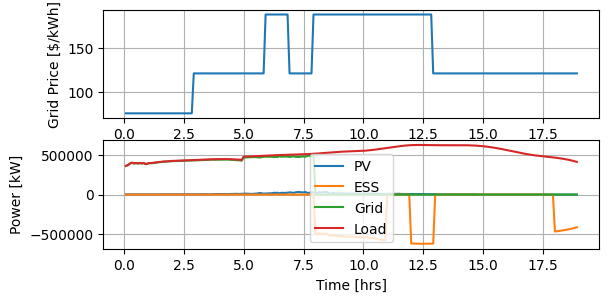

In [96]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)


plt.subplot(3, 1, 2)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.subplot(3, 1, 3)
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(thour, Ppv, thour, Pbatt , thour, Pgrid, thour, Pload)
plt.grid(True)
plt.legend(['PV', 'ESS', 'Grid', 'Load'])
plt.xlabel('Time [hrs]')
plt.ylabel('Power [kW]')

plt.show()


### 비용 계산

In [93]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

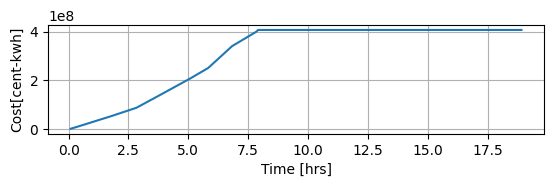

In [94]:
plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [95]:
cumulativeCost[-1] * 10e-6

4065.7500737795885